## 8. Neural networks and deep learning

This week, we'll learn about neural nets and build a model for classifying images of clothes

### 8.1 Fashion classification
Dataset: <br>
* Full: https://github.com/alexeygrigorev/clothing-dataset <br>
* Small: https://github.com/alexeygrigorev/clothing-dataset-small

Links: <br>
* https://cs231n.github.io/

### 8.2 TensorFlow and Keras

* Installing TensorFlow
* Loading Images

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [41]:
import tensorflow as tf
from tensorflow import keras

In [42]:
from tensorflow.keras.preprocessing.image import load_img

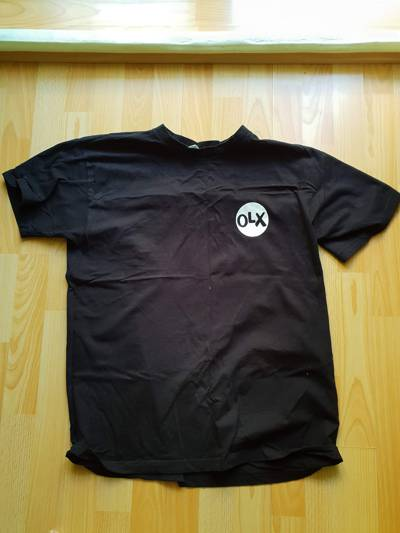

In [43]:
path = './clothing-dataset-small-master/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = f'{path}/{name}'

load_img(fullname)

In [44]:
img = load_img(fullname, target_size=(299,299))

In [45]:
print(img)

<PIL.Image.Image image mode=RGB size=299x299 at 0x22B8B8DAB90>


In [46]:
x = np.array(img)
x.shape

(299, 299, 3)

In [47]:
x

array([[[179, 171,  99],
        [179, 171,  99],
        [181, 173, 101],
        ...,
        [251, 253, 248],
        [251, 253, 248],
        [251, 254, 247]],

       [[188, 179, 112],
        [187, 178, 111],
        [186, 177, 108],
        ...,
        [251, 252, 247],
        [251, 252, 247],
        [251, 252, 246]],

       [[199, 189, 127],
        [200, 190, 128],
        [200, 191, 126],
        ...,
        [250, 251, 245],
        [250, 251, 245],
        [250, 251, 245]],

       ...,

       [[165, 151,  76],
        [173, 159,  84],
        [171, 157,  82],
        ...,
        [183, 135,  25],
        [181, 133,  22],
        [183, 135,  24]],

       [[165, 151,  76],
        [173, 159,  84],
        [171, 157,  82],
        ...,
        [182, 134,  23],
        [180, 132,  21],
        [182, 134,  23]],

       [[165, 151,  76],
        [173, 159,  84],
        [171, 157,  82],
        ...,
        [181, 133,  22],
        [179, 131,  20],
        [182, 134,  23]]

In [48]:
# uint8 - unsigned 8 bit or 1 byte

### 8.3 Pre-trained Convolutional Neural Networks

* Imagenet dataset: https://www.image-net.org/
* Pre-trained models: https://keras.io/api/applications/

In [49]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [50]:
model = Xception(
    weights='imagenet',
    input_shape = (299,299,3)
)

In [51]:
X = np.array([x])

In [52]:
X.shape

(1, 299, 299, 3)

In [53]:
X = preprocess_input(X)

In [54]:
X[0]

array([[[ 0.4039216 ,  0.3411765 , -0.2235294 ],
        [ 0.4039216 ,  0.3411765 , -0.2235294 ],
        [ 0.41960788,  0.35686278, -0.20784312],
        ...,
        [ 0.96862745,  0.9843137 ,  0.94509804],
        [ 0.96862745,  0.9843137 ,  0.94509804],
        [ 0.96862745,  0.99215686,  0.9372549 ]],

       [[ 0.47450984,  0.4039216 , -0.12156862],
        [ 0.4666667 ,  0.39607847, -0.12941176],
        [ 0.45882356,  0.38823533, -0.15294117],
        ...,
        [ 0.96862745,  0.9764706 ,  0.9372549 ],
        [ 0.96862745,  0.9764706 ,  0.9372549 ],
        [ 0.96862745,  0.9764706 ,  0.92941177]],

       [[ 0.56078434,  0.48235297, -0.00392157],
        [ 0.5686275 ,  0.4901961 ,  0.00392163],
        [ 0.5686275 ,  0.49803925, -0.01176471],
        ...,
        [ 0.9607843 ,  0.96862745,  0.92156863],
        [ 0.9607843 ,  0.96862745,  0.92156863],
        [ 0.9607843 ,  0.96862745,  0.92156863]],

       ...,

       [[ 0.2941177 ,  0.18431377, -0.40392154],
        [ 0

In [55]:
pred = model.predict(X)

1/1 [==============================] - 2s 2s/step


In [56]:
pred.shape

(1, 1000)

In [57]:
decode_predictions(pred)

[[('n03595614', 'jersey', 0.68196326),
  ('n02916936', 'bulletproof_vest', 0.038140047),
  ('n04370456', 'sweatshirt', 0.034324735),
  ('n03710637', 'maillot', 0.011354213),
  ('n04525038', 'velvet', 0.001845359)]]

### 8.4 Convolutional neural networks

* Types of layers: convolutional and dense
* Convolutional layers and filters
* Dense layers

There are more layers. Read here: https://cs231n.github.io/

* Write a blog post about CNN

### 8.5 Transfer learning

* Reading data with <code>ImageDataGenerator</code>
* Train <code>Xception</code> on smaller images (150x150)

In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

![alt text](model.png)

In [59]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [60]:
train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small-master/train', 
    target_size=(150,150), 
    batch_size=32
)

Found 3068 images belonging to 10 classes.


In [61]:
X, y = next(train_ds)

In [62]:
X.shape
# batch size, height, width, RGB

(32, 150, 150, 3)

In [63]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [64]:
y[:5]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [65]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small-master/validation', 
    target_size=(150,150), 
    batch_size=32
)

Found 341 images belonging to 10 classes.


In [66]:
base_model = Xception(weights='imagenet',
                      include_top=False, # do not include dense layer
                      input_shape = (150,150,3)
                      )

base_model.trainable = False    # freeze convolutional layer

In [67]:
inputs = keras.Input(shape=(150,150,3))

base = base_model(inputs, training=False)

# pooling = keras.layers.GlobalAveragePooling2D() #convert 3D image (base) to 1D --> Vector values
# vectors = pooling(base)

# simply using Functional Style
vectors = keras.layers.GlobalAveragePooling2D()(base)

# creating Dense Layers
outputs = keras.layers.Dense(10)(vectors)   # 10 - outputs, passing vectors as inputs

model = keras.Model(inputs, outputs)

In [68]:
# Dense Layer ~ Matrix Multiplication

In [69]:
preds =  model.predict(X)

1/1 [==============================] - 4s 4s/step


In [70]:
preds.shape

(32, 10)

In [71]:
preds[0]

array([-0.79554594,  0.39882106, -0.25629786,  1.0194713 , -1.2338804 ,
       -0.22155514, -0.32602984,  0.8517917 ,  0.62763476, -0.76792586],
      dtype=float32)

##### *Training the Model*

In [75]:
# optimizers
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# loss
loss = keras.losses.CategoricalCrossentropy(from_logits=True)


In [76]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [77]:
# epoch - How many times we train one batch, 10 epoch --> the training go over the data 10 times
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 178s 2s/step - loss: 1.3383 - accuracy: 0.6682 - val_loss: 1.0933 - val_accuracy: 0.7566
Epoch 2/10
96/96 [==============================] - 181s 2s/step - loss: 0.5137 - accuracy: 0.8328 - val_loss: 0.7640 - val_accuracy: 0.8065
Epoch 3/10
96/96 [==============================] - 178s 2s/step - loss: 0.3589 - accuracy: 0.8797 - val_loss: 0.9595 - val_accuracy: 0.7625
Epoch 4/10
96/96 [==============================] - 177s 2s/step - loss: 0.2868 - accuracy: 0.9038 - val_loss: 0.9077 - val_accuracy: 0.7683
Epoch 5/10
96/96 [==============================] - 167s 2s/step - loss: 0.1708 - accuracy: 0.9348 - val_loss: 0.9749 - val_accuracy: 0.7830
Epoch 6/10
96/96 [==============================] - 184s 2s/step - loss: 0.1533 - accuracy: 0.9410 - val_loss: 0.8638 - val_accuracy: 0.7977
Epoch 7/10
96/96 [==============================] - 192s 2s/step - loss: 0.0970 - accuracy: 0.9684 - val_loss: 0.8821 - val_accuracy: 0.8035
Epoch 8/10
96

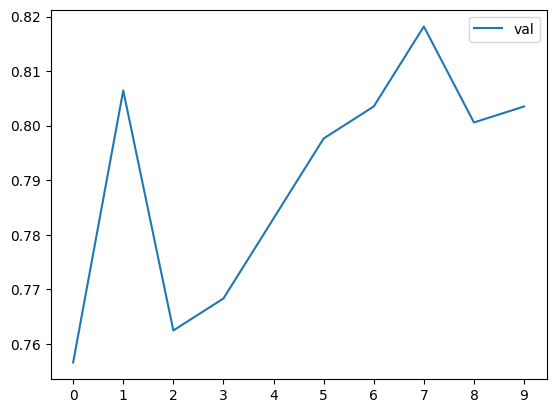

In [82]:
# plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend();

### 8.6 Adjusting the learning rate

* What's the learning rate: (eg: How fast you read)
* Trying different values

In [83]:
def make_model(learning_rate=0.01):
    base_model = Xception(weights='imagenet',
                      include_top=False, # do not include dense layer
                      input_shape = (150,150,3)
                      )

    base_model.trainable = False 

    ###########################################

    inputs = keras.Input(shape=(150,150,3))

    base = base_model(inputs, training=False)

    vectors = keras.layers.GlobalAveragePooling2D()(base)

    outputs = keras.layers.Dense(10)(vectors)

    model = keras.Model(inputs, outputs)

    ###########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )

    return model

In [ ]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    # due to the time constraint, lets assume epoch --> 5
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/10
96/96 [==============================] - 180s 2s/step - loss: 1.9894 - accuracy: 0.3224 - val_loss: 1.6383 - val_accuracy: 0.4897
Epoch 2/10
96/96 [==============================] - 173s 2s/step - loss: 1.4092 - accuracy: 0.5649 - val_loss: 1.2670 - val_accuracy: 0.5777
Epoch 3/10
96/96 [==============================] - 167s 2s/step - loss: 1.1528 - accuracy: 0.6340 - val_loss: 1.0787 - val_accuracy: 0.6657
Epoch 4/10
96/96 [==============================] - 175s 2s/step - loss: 1.0103 - accuracy: 0.6802 - val_loss: 0.9649 - val_accuracy: 0.6950
Epoch 5/10
96/96 [==============================] - 176s 2s/step - loss: 0.9169 - accuracy: 0.7034 - val_loss: 0.8870 - val_accuracy: 0.7273
Epoch 6/10
96/96 [==============================] - 201s 2s/step - loss: 0.8473 - accuracy: 0.7269 - val_loss: 0.8334 - val_accuracy: 0.7449
Epoch 7/10
96/96 [==============================] - 173s 2s/step - loss: 0.7956 - accuracy: 0.7438 - val_loss: 0.7939 - val_accuracy: 0.7595
Epoch 

In [90]:
scores

{'lr': {'loss': [11.129085540771484,
   5.100611209869385,
   4.578614234924316,
   4.125953197479248,
   2.1715004444122314],
  'accuracy': [0.6359191536903381,
   0.7825945019721985,
   0.8168187737464905,
   0.8406127691268921,
   0.8852672576904297],
  'val_loss': [10.224164009094238,
   6.954354286193848,
   19.815401077270508,
   10.676977157592773,
   9.95545482635498],
  'val_accuracy': [0.7184750437736511,
   0.774193525314331,
   0.6275659799575806,
   0.7507331371307373,
   0.7536656856536865]}}

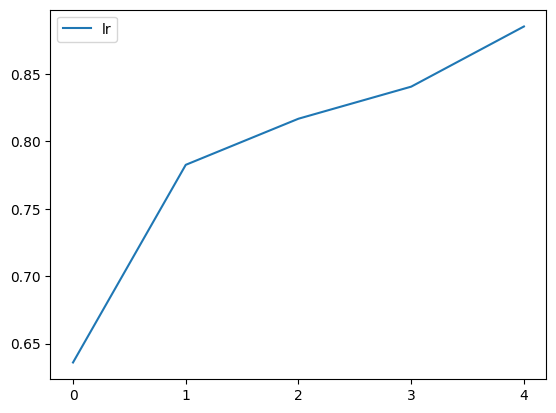

In [89]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=lr)

plt.xticks(np.arange(5))
plt.legend()